# Chronicle Flood Database Intersection with GHSL Built Area dataset

This notebook provides a comprehensive analysis of the Chronicle urban flood dataset, containing over 880,000 flood events worldwide from 2000-2025.


# Imports & Configuration

In [16]:
import pandas as pd
import geopandas as gpd
from shapely import wkt, geometry
from shapely.geometry import box
import rasterio
from rasterstats import zonal_stats
import numpy as np
import folium
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# --- CONFIGURATION ---

# File Paths
chronicle_ds_csv_path = r"D:\Development\RESEARCH\urban_flood_database\chronicle\chronicle_preliminary_huji.csv"
ghs_urban_raster_path = r"D:\Development\RESEARCH\Raanana\data\esa_worldcover\GHS_BUILT_S_E2020_GLOBE_R2023A_54009_100_V1_0.tif"

# Processing Settings
# Set to an integer (e.g., 10000) for testing, or None for full dataset
SAMPLE_SIZE = 1000

# Data Loading & Processing

In [17]:
# 1. Load Data
print(f"--- Loading Data (Sample: {SAMPLE_SIZE}) ---")
if SAMPLE_SIZE:
    chronicle_raw_df = pd.read_csv(chronicle_ds_csv_path, nrows=SAMPLE_SIZE)
else:
    chronicle_raw_df = pd.read_csv(chronicle_ds_csv_path)

# 2. Parse Geometries (WKT to Shapely)
print("Parsing WKT geometries...")
chronicle_raw_df['geometry'] = chronicle_raw_df['geometry_wkt'].apply(wkt.loads)

# 3. Create GeoDataFrame (WGS84)
chronicle_gdf = gpd.GeoDataFrame(chronicle_raw_df, geometry='geometry')
chronicle_gdf.set_crs(epsg=4326, inplace=True)

# 4. Reproject to Match Raster
# We need to open the raster to get its CRS
with rasterio.open(ghs_urban_raster_path) as src:
    ghs_raster_crs = src.crs
    ghs_nodata_value = src.nodata
    print(f"Raster CRS: {ghs_raster_crs}")
    
    print("Reprojecting polygons...")
    chronicle_projected_gdf = chronicle_gdf.to_crs(ghs_raster_crs)

# 5. Calculate Zonal Statistics
print("Calculating zonal stats...")
urban_zonal_stats = zonal_stats(
    chronicle_projected_gdf,
    ghs_urban_raster_path,
    stats=['sum'],
    nodata=ghs_nodata_value
)
urban_stats_df = pd.DataFrame(urban_zonal_stats)

# 6. Calculate Urban Percentage
print("Calculating percentages...")
chronicle_projected_gdf['urban_built_up_area_m2'] = urban_stats_df['sum'].fillna(0)
chronicle_projected_gdf['polygon_total_area_m2'] = chronicle_projected_gdf.area

# Calculation logic: (Built / Total) * 100
chronicle_projected_gdf['urban_percentage'] = np.where(
    chronicle_projected_gdf['polygon_total_area_m2'] > 0,
    (chronicle_projected_gdf['urban_built_up_area_m2'] / chronicle_projected_gdf['polygon_total_area_m2']) * 100,
    0
)

# 7. Final Clean DataFrame (In Memory)
chronicle_urban_df = pd.DataFrame(chronicle_projected_gdf.drop(columns='geometry'))

print(f"--- Done! Processed {len(chronicle_urban_df)} records. ---")
# Optional: Uncomment to save if needed
# chronicle_urban_df.to_csv("output.csv", index=False)

--- Loading Data (Sample: 1000) ---
Parsing WKT geometries...
Raster CRS: ESRI:54009
Reprojecting polygons...
Calculating zonal stats...
Calculating percentages...
--- Done! Processed 1000 records. ---


In [18]:
chronicle_projected_gdf

,Unnamed: 0,uuid,area_km2,version,start_time,end_time,duration_days,geometry_wkt,geometry,urban_built_up_area_m2,polygon_total_area_m2,urban_percentage
0,0,93e48341dbaa4be29a38b856d94206c5,191.436317,v3.1,946684800.0,946684800.0,1,"POLYGON ((-7.6844751 33.499789, -7.5516781 33....","POLYGON ((-688132.701 4050678.544, -676220.624...",4608358.0,1.531473e+08,3.009102
1,1,939149831ea34c3e94712cc42c17c46a,14.208894,v3.1,946684800.0,946684800.0,1,"POLYGON ((-7.9863739 29.745153, -7.9965878 29....","POLYGON ((-733361.579 3614007.704, -734236.037...",751304.0,9.880934e+06,7.603573
2,2,931831f75479454cb3938811e64ce882,28.562733,v3.1,946684800.0,946684800.0,1,"POLYGON ((-98.97432499999999 19.337026, -98.93...","POLYGON ((-9569912.065 2373474.284, -9569153.8...",3757833.0,1.180029e+07,31.845253
3,3,91bc68dde43646289c9e75b7d59e1711,108.562378,v3.1,946684800.0,946684800.0,1,"POLYGON ((30.936502 -29.872152, 30.928104 -29....","POLYGON ((2838552.144 -3628884.525, 2839410.39...",26634641.0,1.273836e+08,20.908999
4,4,8b849511de80423f98918f55af323e7e,0.104375,v3.1,946684800.0,946684800.0,1,"POLYGON ((16.547385 38.687964, 16.549982 38.68...","POLYGON ((1421927.465 4642224.649, 1422135.033...",49138.0,1.051849e+05,46.715826
...,...,...,...,...,...,...,...,...,...,...,...,...
995,995,313b608c518f4d06b9739321458c2c42,39.338462,v3.1,971395200.0,971654400.0,4,"MULTIPOLYGON (((15.503304 38.284525, 15.542878...","MULTIPOLYGON (((1336878.318 4596763.910, 13400...",5203545.0,5.212353e+07,9.983102
996,996,3310eedc9f5a45ffa42b9933f040b5e2,38.284993,v3.1,971395200.0,971654400.0,4,"POLYGON ((10.178347 44.64463, 10.242256 44.723...","POLYGON ((825296.537 5301647.722, 829765.911 5...",1541592.0,3.708824e+07,4.156552
997,997,33416296cee74824ab8fbb15dee60ff1,0.176705,v3.1,971395200.0,971654400.0,4,"POLYGON ((13.467499 46.51065, 13.473164 46.514...","POLYGON ((1069418.486 5503315.819, 1069825.984...",34305.0,2.055646e+05,16.688185
998,998,72dd42ad220a4a7f8316523c3b7f64f9,17.711911,v3.1,971395200.0,971654400.0,4,"POLYGON ((8.155009099999999 44.903857, 8.23550...","POLYGON ((659375.576 5329811.435, 665698.488 5...",4804268.0,3.013409e+07,15.942964


--- Statistics ---
Total events processed: 1000
Events > 20% urban: 262 (26.20%)
CDF at 20% (Events <= 20%): 73.80%
------------------


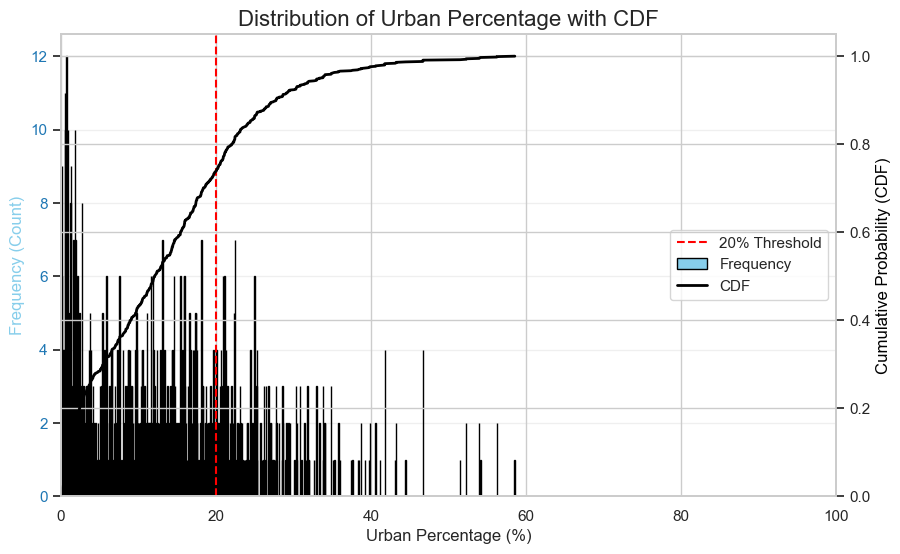

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# --- 1. CALCULATION ---
threshold = 20

# Filter events above threshold
events_above_threshold = chronicle_urban_df[chronicle_urban_df['urban_percentage'] > threshold]
count_above = len(events_above_threshold)
total_events = len(chronicle_urban_df)

# Calculate CDF at the specific threshold (Percentage of events <= threshold)
cdf_at_threshold = (chronicle_urban_df['urban_percentage'] <= threshold).mean() * 100

print("--- Statistics ---")
print(f"Total events processed: {total_events}")
print(f"Events > {threshold}% urban: {count_above} ({100 - cdf_at_threshold:.2f}%)")
print(f"CDF at {threshold}% (Events <= {threshold}%): {cdf_at_threshold:.2f}%")
print("------------------")

# --- 2. PLOTTING ---
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot A: Histogram (Left Axis)
# We use density=False to see the actual counts
ax1.hist(chronicle_urban_df['urban_percentage'], bins=1000, color='skyblue', edgecolor='black', label='Frequency')
ax1.set_xlabel('Urban Percentage (%)', fontsize=12)
ax1.set_ylabel('Frequency (Count)', fontsize=12, color='skyblue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_xlim(0, 100)
ax1.grid(axis='y', alpha=0.3)

# Plot B: CDF (Right Axis)
ax2 = ax1.twinx()  # Instantiate a second axes that shares the same x-axis

# Create CDF data
sorted_data = np.sort(chronicle_urban_df['urban_percentage'])
yvals = np.arange(len(sorted_data)) / float(len(sorted_data) - 1)

# Plot the CDF line
ax2.plot(sorted_data, yvals, color='black', linewidth=2, label='CDF')
ax2.set_ylabel('Cumulative Probability (CDF)', fontsize=12, color='black')
ax2.set_ylim(0, 1.05) # CDF goes from 0 to 1

# Add vertical threshold line
# We add it to ax1 but it crosses both
ax1.axvline(threshold, color='red', linestyle='dashed', linewidth=1.5, label=f'{threshold}% Threshold')

# Combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='center right')

plt.title('Distribution of Urban Percentage with CDF', fontsize=16)
plt.show()

In [23]:
# 1. Filter rows with percentage > 100
anomalies = chronicle_urban_df[chronicle_urban_df['urban_percentage'] > 100]
count = len(anomalies)

print("--- Data Integrity Check ---")
print(f"Total events checked: {len(chronicle_urban_df)}")
print(f"Events with > 100% urban area: {count}")

if count > 0:
    max_val = anomalies['urban_percentage'].max()
    print(f"Highest value found: {max_val:.2f}%")
    
    print("\nTop 5 Anomalies (Preview):")
    # Show UUID, Percentage, and Total Area (often happens in very small polygons)
    print(anomalies[['uuid', 'urban_percentage', 'polygon_total_area_m2']].head())
else:
    print("Status: OK. No values above 100% found.")

--- Data Integrity Check ---
Total events checked: 1000
Events with > 100% urban area: 0
Status: OK. No values above 100% found.


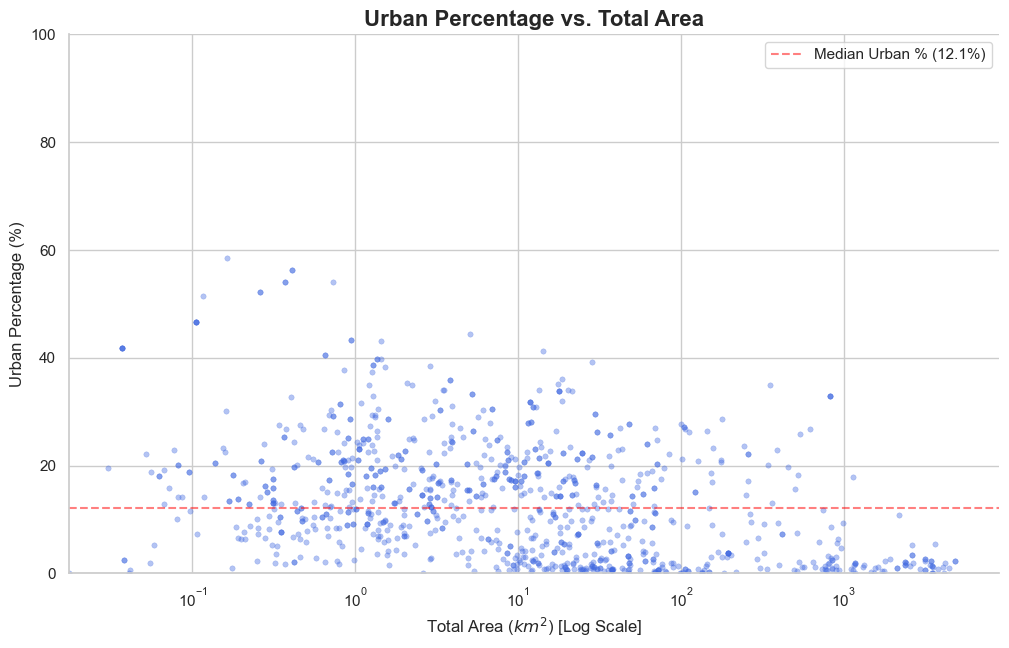

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Create a copy and convert area to km² for better readability
# (1 km² = 1,000,000 m²)
df_plot = chronicle_urban_df.copy()
df_plot['area_km2'] = df_plot['polygon_total_area_m2'] / 1_000_000

# 2. Setup the figure
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 7))

# 3. Create Scatter Plot
sns.scatterplot(
    data=df_plot,
    x='area_km2',
    y='urban_percentage',
    alpha=0.4,       # Transparency helps visualize overlapping points
    edgecolor=None,  # Removes borders from dots for a cleaner look
    s=15,            # Dot size
    color='royalblue'
)

# 4. Set Log Scale for X-axis (Crucial for Area distribution)
plt.xscale('log')

# 5. Set limits and styling
plt.ylim(0, 100)
plt.xlim(left=df_plot['area_km2'].min()) # Start from the smallest polygon

plt.title('Urban Percentage vs. Total Area', fontsize=16, fontweight='bold')
plt.xlabel('Total Area ($km^2$) [Log Scale]', fontsize=12)
plt.ylabel('Urban Percentage (%)', fontsize=12)

# 6. Add a visual helper line (e.g., median urban percentage)
median_val = df_plot['urban_percentage'].median()
plt.axhline(median_val, color='red', linestyle='--', alpha=0.5, label=f'Median Urban % ({median_val:.1f}%)')
plt.legend()

sns.despine()
plt.show()

# Visualization Helper Functions

In [4]:
def get_pixels_from_projected_geom(geom_projected, raster_path):
    """
    Extracts pixels from the raster that intersect with the given geometry.
    Returns a GeoDataFrame of pixel squares with their urban percentage.
    """
    minx, miny, maxx, maxy = geom_projected.bounds
    pixel_geoms, pixel_percentages = [], []

    with rasterio.open(raster_path) as src:
        # Read only the window covering the polygon bounds
        window = rasterio.windows.from_bounds(minx, miny, maxx, maxy, transform=src.transform)
        data = src.read(1, window=window)
        window_transform = src.window_transform(window)
        height, width = data.shape
        
        for row in range(height):
            for col in range(width):
                val = data[row, col]
                if val >= 0:
                    # Create pixel polygon (Square)
                    x1, y1 = window_transform * (col, row)
                    x2, y2 = window_transform * (col + 1, row + 1)
                    pixel_poly = box(min(x1, x2), min(y1, y2), max(x1, x2), max(y1, y2))
                    
                    # Strict check: pixel must touch/intersect the polygon
                    if pixel_poly.intersects(geom_projected):
                        total_area = pixel_poly.area
                        pct = (val / total_area * 100) if total_area > 0 else 0
                        
                        pixel_geoms.append(pixel_poly)
                        pixel_percentages.append(min(pct, 100.0))

    if not pixel_percentages: 
        return gpd.GeoDataFrame()
    
    return gpd.GeoDataFrame(
        {'urban_pct': pixel_percentages}, 
        geometry=pixel_geoms, 
        crs=src.crs
    )

def get_pct_color(value):
    """Returns hex color from Green (0%) to Red (100%)"""
    norm_val = value / 100.0
    cmap = plt.get_cmap('RdYlGn_r') 
    return mcolors.to_hex(cmap(norm_val))

# Selected-event Interactive Map Visualization

In [5]:
# --- SELECT EVENT TO VISUALIZE ---
EVENT_INDEX = 0  # Change this index to view different events

In [6]:
if EVENT_INDEX >= len(chronicle_projected_gdf):
    raise ValueError(f"Index {EVENT_INDEX} out of range.")

# 1. Get Event Data
geom_projected = chronicle_projected_gdf.iloc[EVENT_INDEX]['geometry']
event_uuid = chronicle_urban_df.iloc[EVENT_INDEX]['uuid']
urban_pct_total = chronicle_urban_df.iloc[EVENT_INDEX]['urban_percentage']

print(f"Visualizing Event Index: {EVENT_INDEX}")
print(f"UUID: {event_uuid}")
print(f"Total Urban Percentage: {urban_pct_total:.2f}%")

# 2. Extract Pixels (Intersecting only)
print("Extracting pixels...")
pixel_gdf_projected = get_pixels_from_projected_geom(geom_projected, ghs_urban_raster_path)

# 3. Prepare Map Data (Convert to WGS84 for Folium)
geom_wgs84 = gpd.GeoSeries([geom_projected], crs=chronicle_projected_gdf.crs).to_crs(epsg=4326)[0]

if not pixel_gdf_projected.empty:
    pixel_gdf_wgs84 = pixel_gdf_projected.to_crs(epsg=4326)
else:
    print("Warning: No intersecting pixels found.")
    pixel_gdf_wgs84 = None

# 4. Build Map
centroid = geom_wgs84.centroid
m = folium.Map(location=[centroid.y, centroid.x], zoom_start=13, tiles=None)

# Add Base Layers
folium.TileLayer("OpenStreetMap", name="Streets").add_to(m)
folium.TileLayer(
    tiles="https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}",
    attr="Tiles © Esri",
    name="Satellite",
).add_to(m)

# Layer 1: Flood Polygon (Bottom, Hollow Blue)
folium.GeoJson(
    geom_wgs84,
    name="Flood Event Boundary",
    style_function=lambda x: {'color': 'blue', 'weight': 3, 'fillOpacity': 0}
).add_to(m)

# Layer 2: Pixels (Top, Colored by Density)
if pixel_gdf_wgs84 is not None:
    folium.GeoJson(
        pixel_gdf_wgs84,
        name="Urban Density Pixels",
        style_function=lambda feature: {
            'fillColor': get_pct_color(feature['properties']['urban_pct']),
            'color': 'none',       
            'fillOpacity': 0.6, # Constant opacity so 0% is visible as green
        },
        tooltip=folium.GeoJsonTooltip(fields=['urban_pct'], aliases=['Density (%):'], localize=True)
    ).add_to(m)

# Legend
legend_html = '''
 <div style="position: fixed; bottom: 50px; left: 50px; width: 200px; height: 80px; 
 border:2px solid grey; z-index:9999; background-color:white; opacity: 0.9; padding: 10px; border-radius: 5px;">
 <b>Urban Density (%)</b><br>
 <div style="background: linear-gradient(to right, green, yellow, red); width: 100%; height: 20px; border: 1px solid #ccc;"></div>
 <div style="display: flex; justify-content: space-between; font-size: 12px;"><span>0%</span><span>50%</span><span>100%</span></div>
 </div>
 '''
m.get_root().html.add_child(folium.Element(legend_html))
folium.LayerControl().add_to(m)

# Display Map
m

Visualizing Event Index: 0
UUID: 93e48341dbaa4be29a38b856d94206c5
Total Urban Percentage: 3.03%
Extracting pixels...
